In [1]:
import numpy as np
np.random.seed(2023)
import random
random.seed(2023)
print('[INFO] Using numpy {0}'.format(np.__version__))

import sklearn
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print('[INFO] Using sklearn {0}'.format(sklearn.__version__))

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

# ______________________________________________________________________________
# Globals
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)

infile = '../test2/histos_tba.12.npz'

chsqfile = 'chsq.npz'


[INFO] Using numpy 1.12.1
[INFO] Using sklearn 0.18.1


In [2]:
#### Load data ####

try:
    loaded = np.load(infile)
    the_variables = loaded['variables']
    the_parameters = loaded['parameters']
except:
    print('[ERROR] Failed to load data from file: {0}'.format(infile))

print('[INFO] Loaded the variables with shape {0}'.format(the_variables.shape))
print('[INFO] Loaded the parameters with shape {0}'.format(the_parameters.shape))

[INFO] Loaded the variables with shape (3646057, 76)
[INFO] Loaded the parameters with shape (3646057, 3)


In [3]:
class Encoder(object):

  def __init__(self, x, y, adjust_scale=0):
    if x is not None and y is not None:
      assert(x.shape[1] == (nlayers * 6) + 4)
      assert(y.shape[1] == 3)
      assert(x.shape[0] == y.shape[0])

      self.nentries = x.shape[0]
      self.x_orig  = x
      self.y_orig  = y
      self.x_copy  = x.copy()
      self.y_copy  = y.copy()

      # Get views
      self.x_phi   = self.x_copy[:, nlayers*0:nlayers*1]
      self.x_theta = self.x_copy[:, nlayers*1:nlayers*2]
      self.x_bend  = self.x_copy[:, nlayers*2:nlayers*3]
      self.x_ring  = self.x_copy[:, nlayers*3:nlayers*4]
      self.x_fr    = self.x_copy[:, nlayers*4:nlayers*5]
      self.x_mask  = self.x_copy[:, nlayers*5:nlayers*6].astype(np.bool)  # this makes a copy
      self.x_road  = self.x_copy[:, nlayers*6:nlayers*7]  # ipt, ieta, iphi, iphi_corr
      self.y_pt    = self.y_copy[:, 0]  # q/pT
      self.y_phi   = self.y_copy[:, 1]
      self.y_eta   = self.y_copy[:, 2]
      
      # Make event weight
      #self.w       = np.ones(self.y_pt.shape, dtype=np.float32)
      self.w       = np.abs(self.y_pt)/0.2 + 1.0
      
      # Straightness & zone
      self.x_straightness = self.x_road[:, 0][:, np.newaxis].astype(np.int32)
      self.x_zone         = self.x_road[:, 1][:, np.newaxis].astype(np.int32)
      
      # Subtract median phi from hit phis
      #self.x_phi_median    = self.x_road[:, 2] * 32 - 16  # multiply by 'quadstrip' unit (4 * 8)
      self.x_phi_median    = self.x_road[:, 2] * 16 - 8  # multiply by 'doublestrip' unit (2 * 8)
      self.x_phi_median    = self.x_phi_median[:, np.newaxis]
      self.x_phi          -= self.x_phi_median
      
      # Subtract median theta from hit thetas
      self.x_theta_median  = np.nanmedian(self.x_theta[:,:5], axis=1)  # CSC only
      self.x_theta_median[np.isnan(self.x_theta_median)] = np.nanmedian(self.x_theta[np.isnan(self.x_theta_median)], axis=1)  # use all
      self.x_theta_median  = self.x_theta_median[:, np.newaxis]
      self.x_theta        -= self.x_theta_median
      
      # Standard scales
      if adjust_scale == 0:  # do not adjust
        pass
      elif adjust_scale == 1:  # use mean and std
        self.x_mean  = np.nanmean(self.x_copy, axis=0)
        self.x_std   = np.nanstd(self.x_copy, axis=0)
        self.x_std   = self._handle_zero_in_scale(self.x_std)
        self.x_copy -= self.x_mean
        self.x_copy /= self.x_std
      elif adjust_scale == 2:  # adjust by hand
        self.x_phi   *= 0.000991  # GE1/1 dphi linear correlation with q/pT
        self.x_theta *= (1/12.)   # 12 integer theta units
        self.x_bend  *= 0.188082  # ME1/2 bend linear correlation with q/pT
        x_ring_tmp    = self.x_ring.astype(np.int32)
        x_ring_tmp    = (x_ring_tmp == 1) | (x_ring_tmp == 4)
        np.place(self.x_ring, x_ring_tmp, 0)  # ring 1,4 -> 0
        np.place(self.x_ring, ~x_ring_tmp, 1) # ring 2,3 -> 1
        #self.x_fr     = self.x_fr
      
      # Remove outlier hits by checking hit thetas
      if adjust_scale == 0:  # do not adjust
        x_theta_tmp = np.abs(self.x_theta) > 10000.0
      elif adjust_scale == 1:  # use mean and std
        x_theta_tmp = np.abs(self.x_theta) > 1.0
      elif adjust_scale == 2:  # adjust by hand
        theta_cuts    = np.array((6., 6., 6., 6., 6., 12., 12., 12., 12., 9., 9., 9.), dtype=np.float32)
        theta_cuts   *= (1/12.)   # 12 integer theta units
        assert(len(theta_cuts) == nlayers)
        x_theta_tmp = np.abs(self.x_theta) > theta_cuts
      self.x_phi  [x_theta_tmp] = np.nan
      self.x_theta[x_theta_tmp] = np.nan
      self.x_bend [x_theta_tmp] = np.nan
      self.x_ring [x_theta_tmp] = np.nan
      self.x_fr   [x_theta_tmp] = np.nan
      self.x_mask [x_theta_tmp] = 1.0
      
      # Add variables: straightness, zone, theta_median and mode variables
      self.x_straightness /= np.max(self.x_straightness)
      self.x_zone         /= np.max(self.x_zone)
      self.x_theta_median -= 3.  # scaled to [0,1]
      self.x_theta_median /= 83.
      hits_to_station = np.array((5,1,2,3,4,1,2,3,4,5,2,5), dtype=np.int32)  # '5' denotes ME1/1
      assert(len(hits_to_station) == nlayers)
      self.x_mode_vars = np.zeros((self.nentries, 5), dtype=np.bool)
      self.x_mode_vars[:,0] = np.any(self.x_mask[:,hits_to_station == 5] == 0, axis=1)
      self.x_mode_vars[:,1] = np.any(self.x_mask[:,hits_to_station == 1] == 0, axis=1)
      self.x_mode_vars[:,2] = np.any(self.x_mask[:,hits_to_station == 2] == 0, axis=1)
      self.x_mode_vars[:,3] = np.any(self.x_mask[:,hits_to_station == 3] == 0, axis=1)
      self.x_mode_vars[:,4] = np.any(self.x_mask[:,hits_to_station == 4] == 0, axis=1)
      
      # Remove NaN
      #np.nan_to_num(self.x_copy, copy=False)
      self.x_copy[np.isnan(self.x_copy)] = 0.0

  # Copied from scikit-learn
  def _handle_zero_in_scale(self, scale):
    scale[scale == 0.0] = 1.0
    return scale

  def get_x(self):
    #x_new = self.x_phi
    x_new = np.hstack((self.x_phi, self.x_theta, self.x_bend, self.x_ring, self.x_fr, self.x_mask, self.x_straightness, self.x_zone, self.x_theta_median, self.x_mode_vars))
    return x_new

  def get_x_mask(self):
    x_mask = self.x_mask.copy()
    return x_mask

  def get_x_zone(self):
    x_zone = self.x_zone.copy()
    return x_zone

  def get_y(self):
    y_new = self.y_pt.copy()
    return y_new

  def get_w(self):
    w_new = self.w.copy()
    return w_new

  def save_encoder(self, filepath):
    np.savez_compressed(filepath, x_mean=self.x_mean, x_std=self.x_std)

  def load_endcoder(self, filepath):
    loaded = np.load(filepath)
    self.x_mean = loaded['x_mean']
    self.x_std = loaded['x_std']

In [ ]:
#### Prepare data ####

# Preprocess data
encoder = Encoder(the_variables, the_parameters, adjust_scale=0)
x, y, w, x_mask = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask()
#encoder.save_encoder('encoder.npz')
#print('[INFO] Encoder is saved as encoder.npz')

# 1/pT -> 1/pT * sinh(1.8) / sinh(abs(eta))
y *= (np.sinh(1.8) / np.sinh(np.abs(encoder.y_eta)))

# Split dataset in training and testing
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = train_test_split(x, y, w, x_mask, test_size=0.4)

nvariables = x_train.shape[1]
nparameters = 1
print('[INFO] Using {0} variables and {1} parameters'.format(nvariables, nparameters))

In [ ]:
print x, y, w
print np.mean(x, axis=0)
print np.std(x, axis=0)
print np.isfinite(x).all()

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor
from sklearn.covariance import EmpiricalCovariance, MinCovDet

class ChiSquare(object):
  
  def __init__(self, x, x_mask, y):
    
    self.nentries = 40000 * 3
    self.nvariables = (nlayers*3)
    
    self.x = x[:self.nentries, :self.nvariables]
    self.x_mask = x_mask[:self.nentries]
    self.y = y[:self.nentries]
    
    self.cov = np.ones(self.nvariables, dtype=np.float32)   # mcd
    self.cov_1 = np.ones(self.nvariables, dtype=np.float32) # lr
    self.cov_2 = np.ones(self.nvariables, dtype=np.float32) # ridge
    self.cov_3 = np.ones(self.nvariables, dtype=np.float32) # huber
    self._find_covariance()

  def _find_covariance(self):
    for i in xrange(self.nvariables):
      print('[INFO] Find covariance for var {0}'.format(i))

      lay = (i % nlayers)
      valid = ~self.x_mask[:,lay]
      
      if i in [5, 6, 7, 8, 15, 23]:  # ME2/1f, ME2/1r, ME2/2f, ME2/2r, RE2/2, GE2/1
        valid = valid & ((self.y < -1.0/14) | (self.y > +1.0/14))  # skip high pT part (>14 GeV)
      
      x_i = self.x[:,i][valid]
      y_i = self.y[valid]
      #print x_i, y_i

      if x_i.size == 0:
        continue
      if x_i.size < 400:
        print('[WARNING] Not enough statistics: {0}'.format(x_i.size))

      x_mean = np.mean(x_i)
      #x_i -= x_mean

      x_std = np.std(x_i)
      if x_std == 0.0:
        continue

      # x_phi
      if (i < nlayers):
        # http://scikit-learn.org/stable/modules/generated/sklearn.covariance.MinCovDet.html
        # Minimum Covariance Determinant (MCD): robust estimator of covariance.
        mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
        coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]
        self.cov[i] = coef
        #print coef, mcd.covariance_
        print coef

        # Check with simple linear regression y = a * x
        lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        coef = lr.coef_[0]
        self.cov_1[i] = coef
        print coef
        
        # Check with Ridge regression
        ridge = Ridge(fit_intercept=False, alpha=0.1).fit(x_i[:,np.newaxis], y_i)
        coef = ridge.coef_[0]
        self.cov_2[i] = coef
        print coef
        
        # Check with Huber regression
        huber = HuberRegressor(fit_intercept=False, alpha=0.0, epsilon=1.345).fit(x_i[:,np.newaxis], y_i)
        coef = huber.coef_[0]
        self.cov_3[i] = coef
        print coef

      # x_theta
      elif (nlayers) <= i < (nlayers*2):
        #p = np.percentile(x_i, [2,98])
        #coef = 1.0/(p[1] - p[0])
        if 0 <= lay < 13:  # CSC
          coef = 1.0/6
        elif lay < 22:  # RPC
          coef = 1.0/12
        elif lay < 25:  # GEM
          coef = 1.0/9
        else:
          assert(False)
        self.cov[i] = coef
        self.cov_1[i] = coef
        self.cov_2[i] = coef
        self.cov_3[i] = coef
        print coef

      # x_bend
      elif (nlayers*2) <= i < (nlayers*3):
        # Check with simple linear regression y = a * x
        lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        coef = lr.coef_[0]
        self.cov[i] = coef
        self.cov_1[i] = coef
        self.cov_2[i] = coef
        self.cov_3[i] = coef
        print coef

      else:
        assert(False)

  def save_chsq(self, filepath):
    np.savez_compressed(filepath, cov=self.cov, cov_1=self.cov_1, cov_2=self.cov_2, cov_3=self.cov_3)

  def load_chsq(self, filepath):
    loaded = np.load(filepath)
    self.cov = loaded['cov']
    self.cov_1 = loaded['cov_1']
    self.cov_2 = loaded['cov_2']
    self.cov_3 = loaded['cov_3']
    
    

In [ ]:
chsq = ChiSquare(x_train, x_mask_train, y_train)
chsq.save_chsq('chsq_2GeV.npz')
print('[INFO] ChiSquare is saved as chsq_2GeV.npz')

In [ ]:
print chsq.cov

rank_tmp = np.argsort((chsq.cov ** 2)[:25])
rank = np.arange(25)
rank[rank_tmp] = np.arange(25)

print rank

np.savetxt('chsq_cov.txt', chsq.cov)
np.savetxt('chsq_rank.txt', rank)

In [ ]:
# Set to True to use the old file
if False:
  import shutil
  shutil.copyfile('../test2/chsq_2GeV.11.npz', chsqfile)

In [4]:
#### Prepare data ####

# Preprocess data
encoder = Encoder(the_variables, the_parameters, adjust_scale=2)
x, y, w, x_mask = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask()
#encoder.save_encoder('encoder.npz')
#print('[INFO] Encoder is saved as encoder.npz')

# Split dataset in training and testing
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = train_test_split(x, y, w, x_mask, test_size=0.4)

nvariables = x_train.shape[1]
nparameters = 1
print('[INFO] Using {0} variables and {1} parameters'.format(nvariables, nparameters))

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-numpy/1.12.1-mlhled2/lib/python2.7/site-packages/numpy-1.12.1-py2.7-linux-x86_64.egg/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda6/lib/python2.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater


[INFO] Using 80 variables and 1 parameters


(2187634, 80) (2187634,) (2187634, 12)
0 -0.00167623402399 0.172041712421 [-0.318111    0.32009301]
1 -0.0051369391795 0.059729183823 [-0.12486599  0.115947  ]
2 -0.00261283169033 0.0663230789149 [-0.15063199  0.145677  ]
3 -0.00291088320383 0.0712192063416 [-0.15855999  0.15855999]
4 -0.00320962150988 0.0873562450379 [-0.20117299  0.190272  ]
5 -0.00542658137514 0.0525254911679 [-0.110992  0.103064]
6 -0.00444706380063 0.0378967043408 [-0.095136  0.083244]
7 -0.00258607721954 0.0867003151804 [-0.194236  0.190272]
8 -0.00262444268678 0.10455945868 [-0.221984  0.214056]
9 -0.00215603879249 0.204676232691 [-0.36666998  0.36369699]
10 -0.00192913990192 0.0645557679317 [-0.14964099  0.14964099]
12 0.101083544689 0.120318603506 [-0.08333334  0.41666669]
13 0.102847046491 0.129741824819 [-0.08333334  0.45833334]
14 0.00500370843694 0.0542713845463 [-0.125  0.125]
15 -0.0297580769144 0.0568003387525 [-0.16666667  0.04166667]
16 -0.0334691593253 0.0797878785574 [-0.25        0.08333334]
17 0.0

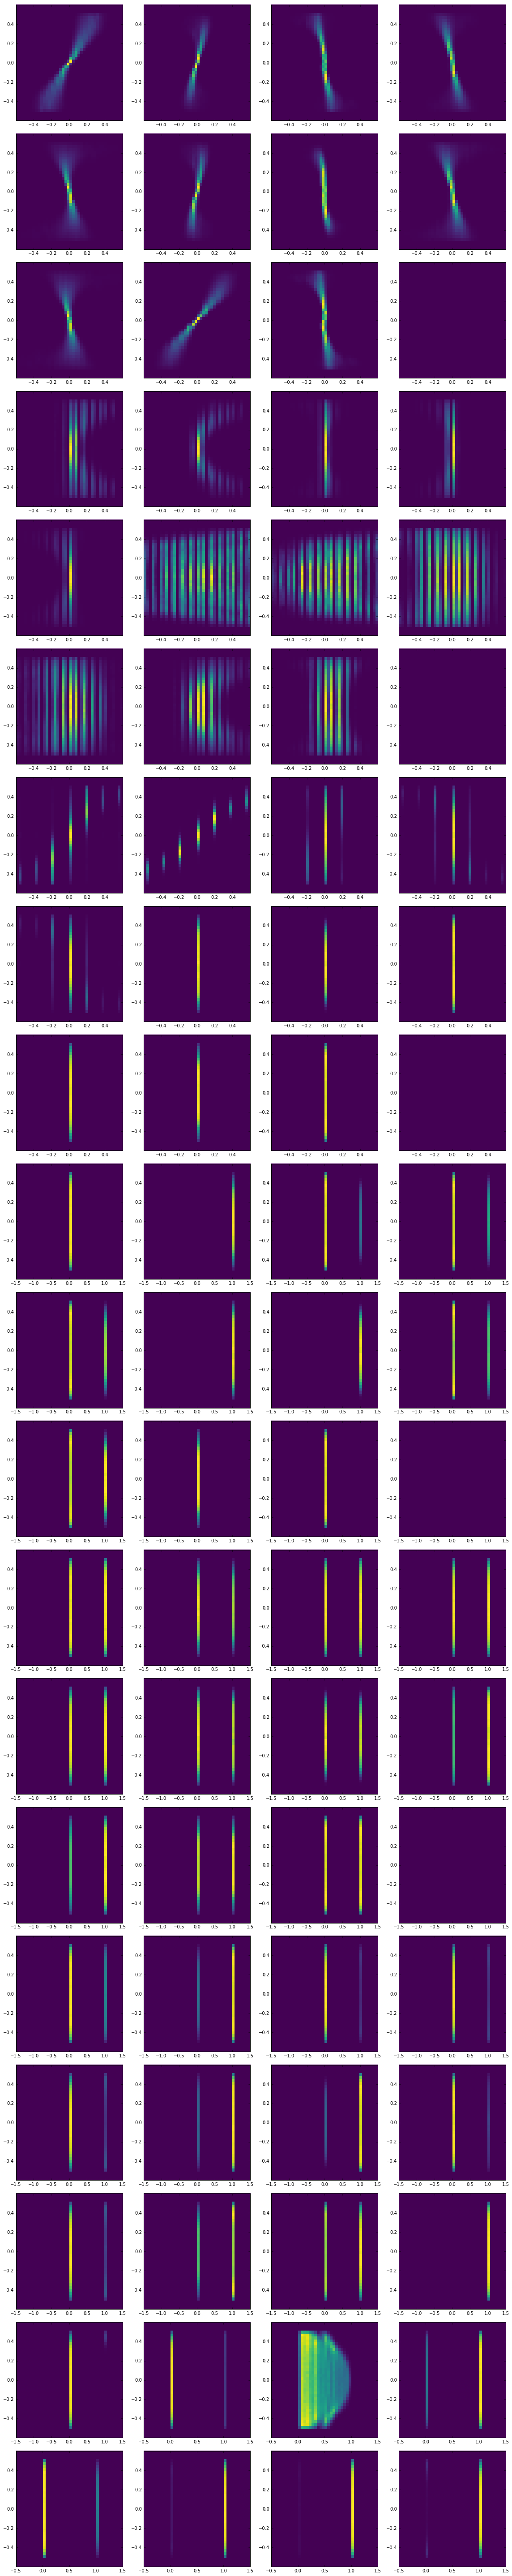

In [10]:
if True:
  print x_train.shape, y_train.shape, x_mask_train.shape

  fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*5):
      mask *= False
    
    valid = ~mask
    x_i = x_train[valid,i]
    y_i = y_train[valid]

    #fig, ax = plt.subplots(tight_layout=True)
    xmin, xmax = -0.6, 0.6
    ymin, ymax = -0.6, 0.6
    if (nlayers*3) <= i < (nlayers*6):
      xmin, xmax = -1.5, 1.5
    elif i == 72:
      xmin, xmax = -1.5, 1.5
    elif i == 73:
      xmin, xmax = -0.5, 1.5
    elif i == 74:
      xmin, xmax = -0.5, 1.5
    elif 75 <= i < 80:
      xmin, xmax = -0.5, 1.5
    
    hist = axs[(i/4, i%4)].hist2d(x_i, y_i, bins=40, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)  #norm=colors.LogNorm(),
    if x_i.size > 0:
      print i, np.mean(x_i), np.std(x_i), np.percentile(x_i, [2,98])

In [ ]:
class MoreChiSquare(object):  # this guy handles data after scaled
  
  def __init__(self, x, x_mask, y):
    
    self.nentries = 40000 * 3 * 15
    self.nvariables = (nlayers*3)
    #self.nvariables = (nlayers)
    
    self.x = x[:self.nentries, :self.nvariables]
    self.x_mask = x_mask[:self.nentries]
    self.y = y[:self.nentries]
    assert(self.x.shape[0] == self.x_mask.shape[0])
    assert(self.x.shape[0] == self.y.shape[0])
    
    theta_var = (nlayers*3) + 0
    self.x_theta_median = x[:self.nentries, theta_var]
    
    self.theta_bins = (10, 0.0, 1.0)
    self.pt_bins = (40, -0.2, 0.2)
    self.chsq_n1 = np.zeros((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.int32)
    self.chsq_n2 = np.zeros((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.int32)
    self.chsq_prob = np.zeros((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.float32)
    self.chsq_prob_1 = np.zeros((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.float32)
    self.chsq_offset = np.zeros((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.float32)
    self.chsq_scale = np.ones((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.float32)
    self.chsq_offset_1 = np.zeros((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.float32)
    self.chsq_scale_1 = np.ones((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.float32)
    self._find_difference()

  def _find_bin(self, x, bins):
    x = np.clip(x, bins[1], bins[2]-1e-8)
    binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
    return int(binx)

  def _find_theta_bin(self, theta):
    return self._find_bin(theta, self.theta_bins)

  def _find_pt_bin(self, pt):
    return self._find_bin(pt, self.pt_bins)

  def _find_difference(self):
    
    print('[INFO] Make bins for theta and pt')
    chsq_ipt = np.vectorize(self._find_pt_bin)(np.clip(self.y, self.pt_bins[1], self.pt_bins[2]))
    chsq_itheta = np.vectorize(self._find_theta_bin)(self.x_theta_median)
    
    for itheta, ipt in zip(chsq_itheta, chsq_ipt):
      self.chsq_n2[itheta,ipt] += 1
    
    for i in xrange(self.nvariables):
      print('[INFO] Find difference for var {0}'.format(i))

      lay = (i % nlayers)
      valid = ~self.x_mask[:,lay]
      x_i = self.x[:,i][valid]

      if x_i.size == 0:
        continue
      if x_i.size < 400:
        print('[WARNING] Not enough statistics: {0}'.format(x_i.size))

      #y_i = self.y[valid]
      #theta_i = self.x_theta_median[valid]
      
      chsq_ipt_i = chsq_ipt[valid]
      chsq_itheta_i = chsq_itheta[valid]
      
      print x_i.shape, chsq_itheta_i.shape, chsq_ipt_i.shape
      
      # Reuse the pattern technology
      patterns = np.empty((self.theta_bins[0], self.pt_bins[0]), dtype=np.object)
      for ind in np.ndindex(patterns.shape):
        patterns[ind] = []
      
      for itheta, ipt, x in zip(chsq_itheta_i, chsq_ipt_i, x_i):
        self.chsq_n1[itheta,ipt,i] += 1
        patterns[itheta,ipt].append(x)
    
      #print self.chsq_n1[...,i], self.chsq_n2[...,i]
      self.chsq_prob[...,i] = np.true_divide(self.chsq_n1[...,i], self.chsq_n2[...,i])

      for ind in np.ndindex(patterns.shape):
        if len(patterns[ind]) == 0:
          continue
        if len(patterns[ind]) < 40:
          print('[WARNING] Not enough statistics: {0} {1}'.format(ind, len(patterns[ind])))
          patterns[ind] = []
          continue
        
        ind2 = ind + (i,)
        prob = 100. - 50. * (1.0 - self.chsq_prob[ind2])
        
        p = np.percentile(patterns[ind], [25, 50, 75, prob], overwrite_input=True)
        patterns[ind] = p
      
      for ind in np.ndindex(patterns.shape):
        p = patterns[ind]
        if len(p) == 0:
          p = [-0.5, 0, 0.5, 0]
        assert(len(p) == 4)
        
        ind2 = ind + (i,)
        self.chsq_offset[ind2] = p[1]
        if p[2] > p[0]:
          self.chsq_scale[ind2] = 1.0 / (p[2] - p[0])
        else:
          self.chsq_scale[ind2] = 1.0
        self.chsq_prob_1[ind2] = p[3]
      
      smooth = True
      if smooth:
        from scipy.interpolate import Rbf
        x = [self.pt_bins[1] + (ipt+0.5)/self.pt_bins[0]*(self.pt_bins[2] - self.pt_bins[1]) for ipt in xrange(self.pt_bins[0])]
        for itheta in xrange(self.theta_bins[0]):
          assert(len(x) == len(self.chsq_offset[itheta,:,i]))
          rbf = Rbf(x, self.chsq_offset[itheta,:,i], smooth = 0.3, function='multiquadric')
          self.chsq_offset_1[itheta,:,i] = rbf(x)
          rbf = Rbf(x, self.chsq_scale[itheta,:,i], smooth = 0.3, function='multiquadric')
          self.chsq_scale_1[itheta,:,i] = rbf(x)


  def save_chsq(self, filepath):
    with np.load(chsqfile) as loaded:
      self.cov = loaded['cov']
      self.cov_1 = loaded['cov_1']
      self.cov_2 = loaded['cov_2']
      self.cov_3 = loaded['cov_3']
    np.savez_compressed(filepath, cov=self.cov, cov_1=self.cov_1, cov_2=self.cov_2, cov_3=self.cov_3, 
                        chsq_offset=self.chsq_offset, chsq_scale=self.chsq_scale, chsq_offset_1=self.chsq_offset_1, chsq_scale_1=self.chsq_scale_1,
                        chsq_prob=self.chsq_prob, chsq_prob_1=self.chsq_prob_1)

  def load_chsq(self, filepath):
    loaded = np.load(filepath)
    self.cov = loaded['cov']
    self.cov_1 = loaded['cov_1']
    self.cov_2 = loaded['cov_2']
    self.cov_3 = loaded['cov_3']
    self.chsq_offset = loaded['chsq_offset']
    self.chsq_scale = loaded['chsq_scale']
    self.chsq_offset_1 = loaded['chsq_offset_1']
    self.chsq_scale_1 = loaded['chsq_scale_1']
    self.chsq_prob = loaded['chsq_prob']
    self.chsq_prob_1 = loaded['chsq_prob_1']
    

In [ ]:
chsq = MoreChiSquare(x_train, x_mask_train, y_train)
chsq.save_chsq('chsq_2GeV.npz')
print('[INFO] MoreChiSquare is saved as chsq_2GeV.npz')

In [ ]:
#print chsq.chsq_n1
#print chsq.chsq_n2
print chsq.chsq_prob
print chsq.chsq_prob_1
#print chsq.chsq_offset
#print chsq.chsq_scale
print chsq.chsq_offset_1
print chsq.chsq_scale_1
print np.where(chsq.chsq_scale<=0)
print np.where(chsq.chsq_scale_1<=0)

In [ ]:
# Set to True to use the old file
if True:
  import shutil
  shutil.copyfile('../test2/chsq_2GeV.11.npz', chsqfile)
  #
  chsq.load_chsq(chsqfile)

In [ ]:
if True:
  print x_train.shape, y_train.shape, x_mask_train.shape
  
  nvariables = (nlayers*3)
  theta_var = (nlayers*3) + 0
  x_theta_median_train = x_train[:, theta_var]
  
  #chsq_ipt = np.apply_along_axis(chsq._find_pt_bin, 0, np.clip(y_train, chsq.pt_bins[1], chsq.pt_bins[2]))
  #chsq_itheta = np.apply_along_axis(chsq._find_theta_bin, 0, x_theta_median_train)
  chsq_ipt = np.vectorize(chsq._find_pt_bin)(np.clip(y_train, chsq.pt_bins[1], chsq.pt_bins[2]))
  chsq_itheta = np.vectorize(chsq._find_theta_bin)(x_theta_median_train)
  
  offset = chsq.chsq_offset[chsq_itheta, chsq_ipt]
  scale = chsq.chsq_scale[chsq_itheta, chsq_ipt]
  print offset.shape, scale.shape
  

  fig, axs = plt.subplots(76/4, 4, figsize=(4*4,4*76/4), tight_layout=True)

  for i in xrange(nvariables):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*3):
      mask *= False
    
    valid = ~mask
    x_i = x_train[valid,i]
    y_i = y_train[valid]
    
    x_i -= offset[valid,i]
    x_i *= scale[valid,i]

    #fig, ax = plt.subplots(tight_layout=True)
    xmin, xmax = -4.1, 4.1
    hist = axs[(i/4, i%4)].hist(x_i, bins=41, range=[xmin, xmax])
    if x_i.size > 0:
      print i, np.mean(x_i), np.std(x_i), np.percentile(x_i, [2,98])

In [ ]:
# minbias events
with np.load('histos_tbb_2GeV_add.npz') as data:
  minbias_variables = data['variables']
  minbias_predictions = data['predictions']  
  print minbias_variables.shape, minbias_predictions.shape
  
  dummy_1 = np.zeros(minbias_predictions.shape, dtype=np.float32) + 0
  dummy_2 = np.zeros(minbias_predictions.shape, dtype=np.float32) + 1.8
  minbias_predictions = np.hstack((minbias_predictions, dummy_1, dummy_2))
  
encoder = Encoder(minbias_variables, minbias_predictions, adjust_scale=2)
x_minbias, y_minbias, w_minbias, x_mask_minbias = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask()

In [ ]:
if True:
  print x_minbias.shape, y_minbias.shape, x_mask_minbias.shape
  
  nvariables = (nlayers*3)
  theta_var = (nlayers*3) + 0
  x_theta_median_minbias = x_minbias[:, theta_var]
  
  #chsq_ipt = np.apply_along_axis(chsq._find_pt_bin, 0, np.clip(y_minbias, chsq.pt_bins[1], chsq.pt_bins[2]))
  #chsq_itheta = np.apply_along_axis(chsq._find_theta_bin, 0, x_theta_median_minbias)
  chsq_ipt = np.vectorize(chsq._find_pt_bin)(np.clip(y_minbias, chsq.pt_bins[1], chsq.pt_bins[2]))
  chsq_itheta = np.vectorize(chsq._find_theta_bin)(x_theta_median_minbias)
  
  offset = chsq.chsq_offset[chsq_itheta, chsq_ipt]
  scale = chsq.chsq_scale[chsq_itheta, chsq_ipt]
  print offset.shape, scale.shape
  

  fig, axs = plt.subplots(76/4, 4, figsize=(4*4,4*76/4), tight_layout=True)

  for i in xrange(nvariables):
    lay = (i % nlayers)
    mask = x_mask_minbias[...,lay].copy()
    if i >= (nlayers*3):
      mask *= False
    
    valid = ~mask
    x_i = x_minbias[valid,i]
    y_i = y_minbias[valid]
    
    x_i -= offset[valid,i]
    x_i *= scale[valid,i]

    #fig, ax = plt.subplots(tight_layout=True)
    xmin, xmax = -4.1, 4.1
    hist = axs[(i/4, i%4)].hist(x_i, bins=41, range=[xmin, xmax])
    if x_i.size > 0:
      print i, np.mean(x_i), np.std(x_i), np.percentile(x_i, [2,98])

In [ ]:
print x_mask_train[:10]

In [ ]:
#### Application ####

import ROOT

ROOT.gROOT.LoadMacro("tdrstyle.C")
ROOT.gROOT.ProcessLine("setTDRStyle();")
ROOT.gStyle.SetPalette(57)  # kBird
ROOT.gStyle.SetPadGridX(True)
ROOT.gStyle.SetPadGridY(True)

h1a = ROOT.TEfficiency("effa", "effa", 50, 0, 100)
h1b = ROOT.TEfficiency("effb", "effb", 50, 0, 100)
h2a = ROOT.TH2F("h2a", "h2a", 13, 0, 13, 100, 0, 100)
h2b = ROOT.TH2F("h2b", "h2b", 13, 0, 13, 100, 0, 100)
n2a = []
n2b = []

layer_names = [
  "ME1/1f", "ME1/1r", "ME1/2f", "ME1/2r", "ME1/3", "ME2/1f", "ME2/1r", "ME2/2f", "ME2/2r", "ME3/1", "ME3/2", "ME4/1", "ME4/2",
  "RE1/2f", "RE1/2r", "RE2/2", "RE3/1", "RE3/2", "RE3/3", "RE4/1", "RE4/2", "RE4/3",
  "GE1/1", "GE2/1", "ME0",
]
layer_names = np.array(layer_names)


def calculate_chsq(x, x_mask, offset, scale, prob, delta=1.345):
  valid = ~x_mask
  valid = np.tile(valid,3)
  #valid[nlayers*1:nlayers*2] = False  # do not use thetas
  x -= offset
  x *= scale
  
  rpc_penalty = True
  if rpc_penalty:
    rpc_vars = np.zeros(nlayers, dtype=np.bool)
    rpc_vars[13:22] = True
    x[np.tile(rpc_vars,3)] *= 2
  
  x = x[valid]
  #x **= 2
  x = np.abs(x)
  x = np.where(x < delta, 0.5*np.square(x), delta * (x - 0.5*delta))
  chi2 = x.sum()
  ndof = (x_mask == False).sum()
  
  invalid = x_mask
  xx = prob.copy()
  xx -= offset
  xx *= scale
  xx = xx[:nlayers]
  xx = xx[invalid]
  xx = np.abs(xx)
  xx = np.where(xx < delta, 0.5*np.square(xx), delta * (xx - 0.5*delta))
  #xx = 0.5*np.square(xx)
  chi2_1 = xx.sum()
  #chi2 += 5 * chi2_1
  return (ndof, chi2, chi2_1, x)


#def simple_trigger(ndof, chi2):
#  assert(np.isfinite(chi2))
#  if 0 <= ndof <= 3:
#    return chi2 < 12.28219128
#  elif ndof == 4:
#    return chi2 < 12.82688751
#  elif ndof == 5:
#    return chi2 < 18.
#  elif ndof == 6:
#    return chi2 < 20.
#  elif ndof == 7:
#    return chi2 < 25.
#  elif ndof == 8:
#    return chi2 < 30.
#  else:
#    return chi2 < 75.

def simple_trigger(ndof, chi2):
  assert(np.isfinite(chi2))
  if 0 <= ndof <= 3:
    return chi2 < 7.5
  elif ndof == 4:
    return chi2 < 10.
  elif ndof == 5:
    return chi2 < 18.7
  elif ndof == 6:
    return chi2 < 21.5
  else:
    return chi2 < 35.

  
nvariables_to_scale = chsq.nvariables
nentries_test = 100000 * 4
x_copy = x_train[:nentries_test, :nvariables_to_scale].copy()
y_copy = y_train[:nentries_test].copy()

theta_var = (nlayers*3) + 0
theta_copy = x_train[:nentries_test, theta_var].copy()

x_mask_copy = x_mask_train[:nentries_test].copy()


# Loop over events
for i in xrange(nentries_test):
  x = x_copy[i]
  y = y_copy[i]
  theta = theta_copy[i]
  x_mask = x_mask_copy[i]
  
  #print x, y, theta, x_mask
  
  if np.abs(y) > 1.0/14:  # ignore less than 14 GeV tracks
    continue
  
  itheta = chsq._find_theta_bin(theta)
  ipt = chsq._find_pt_bin(y)
  offset = chsq.chsq_offset_1[itheta,ipt]
  scale = chsq.chsq_scale_1[itheta,ipt]
  prob = chsq.chsq_prob_1[itheta,ipt]
  
  (ndof, chi2, chi2_1, x) = calculate_chsq(x, x_mask, offset, scale, prob)
  
  h2a.Fill(ndof, chi2)
  n2a.append((ndof, chi2))
  
  trigger = simple_trigger(ndof, chi2)
  h1a.Fill(trigger, np.abs(1.0/y))
  
  if i < 40:
    print i, np.abs(1.0/y), ndof, chi2, chi2_1, layer_names[~x_mask], x


In [ ]:
#nvariables_to_scale = chsq.nvariables
nentries_test = x_minbias.shape[0]
x_copy = x_minbias[:nentries_test, :nvariables_to_scale].copy()
y_copy = y_minbias[:nentries_test].copy()

theta_var = (nlayers*3) + 0
theta_copy = x_minbias[:nentries_test, theta_var].copy()

x_mask_copy = x_mask_minbias[:nentries_test].copy()


# Loop over events
for i in xrange(nentries_test):
  x = x_copy[i]
  y = y_copy[i]
  theta = theta_copy[i]
  x_mask = x_mask_copy[i]
  
  #print x, y, theta, x_mask
  
  x_mode_vars = x_minbias[i, nlayers*3+1:nlayers*3+6]
  trk_mode = 0
  for i_mode_var, x_mode_var in enumerate(x_mode_vars):
    if i_mode_var == 0:
      station = 1
    else:
      station = i_mode_var
    if x_mode_var:
      trk_mode |= (1 << (4 - station))
  if trk_mode not in (11,13,14,15):  # single muon
    continue
  
  if np.abs(y) > 1.0/14:  # ignore less than 14 GeV tracks
    continue
  
  itheta = chsq._find_theta_bin(theta)
  ipt = chsq._find_pt_bin(y)
  offset = chsq.chsq_offset_1[itheta,ipt]
  scale = chsq.chsq_scale_1[itheta,ipt]
  prob = chsq.chsq_prob_1[itheta,ipt]
  
  (ndof, chi2, chi2_1, x) = calculate_chsq(x, x_mask, offset, scale, prob)
  
  h2b.Fill(ndof, chi2)
  n2b.append((ndof, chi2))
  
  trigger = simple_trigger(ndof, chi2)
  h1b.Fill(trigger, np.abs(1.0/y))
  
  if i < 400:
    print i, np.abs(1.0/y), ndof, chi2, chi2_1, layer_names[~x_mask], x
  

In [ ]:
c = ROOT.TCanvas()
h1a.Draw("ap")
c.Draw()

In [ ]:
c = ROOT.TCanvas()
h1b.Draw("ap")
c.Draw()

In [ ]:
c = ROOT.TCanvas()
h2a.Draw("COLZ")
c.Draw()

In [ ]:
c = ROOT.TCanvas()
h2b.Draw("COLZ")
c.Draw()

In [ ]:
n2a = np.asarray(n2a)
n2b = np.asarray(n2b)

print n2a.shape, n2b.shape
for i in xrange(13):
  print i, len(n2a[n2a[:,0] == i]), len(n2b[n2b[:,0] == i])

  
fig, axs = plt.subplots(4, 4, figsize=(5*2,5*2), tight_layout=True)

for i in xrange(8):
  if i == 0:
    ind_a = (0 <= n2a[:,0]) & (n2a[:,0] < 4)
    ind_b = (0 <= n2b[:,0]) & (n2b[:,0] < 4)
  elif i == 7:
    ind_a = (10 <= n2a[:,0]) & (n2a[:,0] < 16)
    ind_b = (10 <= n2b[:,0]) & (n2b[:,0] < 16)
  else:
    ind_a = ((i+3) <= n2a[:,0]) & (n2a[:,0] < (i+4))
    ind_b = ((i+3) <= n2b[:,0]) & (n2b[:,0] < (i+4))  

  xmin, xmax = 0., 50.
  hist = axs[(i/4, i%4)].hist(n2b[ind_b,1], bins=50, range=[xmin, xmax], alpha=0.6, normed=True)
  hist = axs[(i/4, i%4)].hist(n2a[ind_a,1], bins=50, range=[xmin, xmax], alpha=0.6, normed=True)
  
  print i, np.percentile(n2a[ind_a,1], [90, 92, 94, 95, 96, 97, 97.5, 98, 99, 99.5], overwrite_input=True)
  
  # ROC
  sig = np.clip(np.sort(n2a[ind_a,1]), 0., 99.)
  bkg = np.clip(np.sort(n2b[ind_b,1]), 0., 99.)
  nsig = len(sig)
  nbkg = len(bkg)
  print i, nsig, nbkg
  
  sig_cut = sig[:,np.newaxis] < np.linspace(1,100,100)
  bkg_cut = bkg[:,np.newaxis] < np.linspace(1,100,100)
  #print sig_cut.shape, bkg_cut.shape
  
  sig_eff = np.sum(sig_cut, axis=0)
  bkg_eff = np.sum(bkg_cut, axis=0)
  #print sig_eff.shape, bkg_eff.shape
  
  sig_eff = np.true_divide(sig_eff, nsig)
  bkg_eff = np.true_divide(bkg_eff, nbkg)
  #print sig_eff
  #print bkg_eff
  
  j = i + 8
  scat = axs[(j/4, j%4)].scatter(bkg_eff, sig_eff)
  axs[(j/4, j%4)].set_xlim(0, 1)
  axs[(j/4, j%4)].set_ylim(0.9, 1)


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


X = np.vstack((n2a, n2b))
y_a = np.ones((n2a.shape[0],1), dtype=np.float32)
y_b = np.zeros((n2b.shape[0],1), dtype=np.float32)
y = np.vstack((y_a, y_b))[:,0]

#X = np.vstack((n2a[:10000], n2b[:10000]))
#y_a = np.ones((n2a.shape[0],1), dtype=np.float32)
#y_b = np.zeros((n2b.shape[0],1), dtype=np.float32)
#y = np.vstack((y_a[:10000], y_b[:10000]))[:,0]

print('[INFO] Start training.')
#clf = SVC(kernel='linear', C=0.5)
#clf = SVC(kernel='rbf', gamma=0.7, C=1.0)
#clf = SVC(kernel='poly', degree=3, C=1.0)
clf = RandomForestClassifier(max_depth=3, n_estimators=50, max_features=1)
clf = clf.fit(X,y)
print('[INFO] Done training.')

fig, ax = plt.subplots(tight_layout=True, figsize=(6,6))

X0, X1 = X[:, 0], X[:, 1]
xx, yy = np.meshgrid(np.linspace(0,13,14), np.linspace(0,100,51))

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())


In [ ]:
########################## PLEASE IGNORE

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.pipeline import Pipeline


if True:
  x_copy  = the_variables.copy()
  y_copy  = the_parameters.copy()
  
  nentries = 1000000
  x_copy  = x_copy[:nentries]
  y_copy  = y_copy[:nentries]
  
  x_phi   = x_copy[:, nlayers*0:nlayers*1]
  x_theta = x_copy[:, nlayers*1:nlayers*2]
  x_bend  = x_copy[:, nlayers*2:nlayers*3]
  #
  x_mask  = x_copy[:, nlayers*5:nlayers*6].astype(np.bool)
  x_road  = x_copy[:, nlayers*6:nlayers*7]
  
  x_phi_median = x_road[:, 2] * 16 - 8  # multiply by 'doublestrip' unit (2 * 8)
  
  x_theta_median = np.nanmedian(x_theta, axis=1)
  
  x_phi_ge11   = x_phi[:, 9] - x_phi_median
  valid_ge11   = ~x_mask[:, 9]
  
  x_theta_me12 = x_theta[:, 1] - x_theta_median
  valid_me12   = ~x_mask[:, 1]
  
  x_bend_me12  = x_bend[:, 1]
  valid_me12   = ~x_mask[:, 1]
  
  y_pt    = y_copy[:, 0]
  y_phi   = y_copy[:, 1]
  y_eta   = y_copy[:, 2]
  
  # 1/pT -> 1/pT * sinh(1.8) / sinh(eta)
  y_pt    = y_pt.copy() * (np.sinh(1.8) / np.sinh(np.abs(y_eta)))
  
  # ______________________________________________________________________________
  x_i = x_phi_ge11
  y_i = y_pt
  
  x_i = x_i[valid_ge11]
  y_i = y_i[valid_ge11]
  
  mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
  coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]
  #print mcd.covariance_
  print coef
  
  xmin, xmax = -600, 600
  ymin, ymax = -0.6, 0.6
  
  fig, ax = plt.subplots(tight_layout=True)
  ax.hist2d(x_i, y_i, bins=40, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)  #norm=colors.LogNorm(),
  
  fig, ax = plt.subplots(tight_layout=True)
  ax.hist2d(x_i * coef, y_i, bins=40, range=[[ymin, ymax], [ymin, ymax]], cmap=plt.cm.viridis)  #norm=colors.LogNorm(),
  
  # ______________________________________________________________________________
  x_i = x_theta_me12
  y_i = np.abs(y_pt)
  
  x_i = x_i[valid_me12]
  y_i = y_i[valid_me12]
  
  # http://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions
  model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                    ('linear', LinearRegression(fit_intercept=False))])
  model = model.fit(x_i[:, np.newaxis], y_i)
  coef = model.named_steps['linear'].coef_[1]
  #print model.named_steps['linear'].coef_
  print coef
  
  xmin, xmax = 0, 12
  ymin, ymax = 0, 0.6
  
  fig, ax = plt.subplots(tight_layout=True)
  ax.hist2d(x_i, y_i, bins=40, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)  #norm=colors.LogNorm(),
  
  fig, ax = plt.subplots(tight_layout=True)
  ax.hist2d(x_i * coef, y_i, bins=40, range=[[ymin, ymax], [ymin, ymax]], cmap=plt.cm.viridis)  #norm=colors.LogNorm(),
  
  # ______________________________________________________________________________
  x_i = x_bend_me12
  y_i = y_pt
  
  x_i = x_i[valid_me12]
  y_i = y_i[valid_me12]
  
  lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
  coef = lr.coef_[0]
  print coef
  
  xmin, xmax = -6, 6
  ymin, ymax = -0.6, 0.6
  
  fig, ax = plt.subplots(tight_layout=True)
  ax.hist2d(x_i, y_i, bins=40, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)  #norm=colors.LogNorm(),
  
  fig, ax = plt.subplots(tight_layout=True)
  ax.hist2d(x_i * coef, y_i, bins=40, range=[[ymin, ymax], [ymin, ymax]], cmap=plt.cm.viridis)  #norm=colors.LogNorm(),
  
  